<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 5</div>

$\textbf{Auteur}$ : Adel Nabli


$\textbf{ID}$: 20121744

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import bernoulli
from scipy.special import expit
from tqdm import tqdm

# Gibbs sampling

We want to have an estimation $\hat{\mu}_s$ of the moments $\mathbb{E}[X_s]$ at each nodes using a Gibbs sampling. Our estimate is thus: $\hat{\mu}_s = \dfrac{1}{T-T_0} \sum_{t=T_0 +1}^T X_s$ with $T_0 = 1000$ the burn-in time and $T=6000$ the total number of epochs.

Thus, at each epoch, we will draw an example of each random variable $X_k$ in the UGM, knowing that $X_k \sim Bernoulli(p_k)$ and $p_k = p(x_k =1 | x_{\lnot k}) = sigmoid(\eta_k x_k + \sum_{l \in N_k} \eta_{kl} x_l)$ with:
* $N_k$ the Markov-blanket of the node $k$,
* $\eta_k = (-1)^k$ and $\eta_{st}=0.5$,
* $\lnot k = 1:49 \backslash k$


Having a grid, instead of using $"k"$, we can refer to a node with its coordinates $(i,j)$ in the grid, with $i,j \in [\![1,7]\!]^2$. Thus, by looking at the UGM we have, we can say that the markov blanket of the $node_{i,j}$ is composed of the set of nodes having the coordinates $\{ ( i-1 \mod 7, j), ( i+1 \mod 7, j), ( i, j-1 \mod 7), ( i, j+1 \mod 7) \}$.

Moreover, from the UGM, we can also say that $k= (i-1) \times 7 + j$ when we want to compute $\eta_k$

___________________

**ALGORITHM**:

* **Initialize** randomly $X^{(0)}$, with zeros $\mu$
* **For $t \in [\![1, T]\!]$**:

$\hspace{2 cm} - $ **For** every node $X_k^{(t)}$:

$\hspace{3 cm} - $ **compute** $p_k^{(t)}$

$\hspace{3 cm} - $ **Do** $X_k^{(t)} = Bernoulli(p_k^{(t)})$

$\hspace{2 cm} - $ **If** $t>T_0, \; \mu = \mu + X^{(t)}$

* **Return** $\dfrac{\mu}{T-T_0}$

__________________


In [49]:
def Gibbs_Sampling():
    
    X = bernoulli.rvs(np.random.random((7,7)))
    mu = np.zeros((7,7))
    
    for t in tqdm(range(6000)):
        
        for i in range(7):
            
            for j in range(7):
                
                eta_k = (-1)**(i*7 + j+1)
                sum_k = 0.5*(X[(i-1)%7,j] + X[(i+1)%7,j] + X[i, (j-1)%7] + X[i, (j+1)%7])
                p_k = expit(X[i,j]*eta_k + sum_k)
                X[i,j] = bernoulli.rvs(p_k)
        
        if t >= 1000:
            
            mu += X
            
    return(mu/5000)

In [50]:
Gibbs_Sampling()

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:14<00:00, 400.67it/s]


array([[0.7072, 0.912 , 0.7198, 0.9082, 0.7284, 0.907 , 0.7098],
       [0.9124, 0.746 , 0.9006, 0.7288, 0.9082, 0.7328, 0.908 ],
       [0.712 , 0.902 , 0.735 , 0.9058, 0.72  , 0.8946, 0.7142],
       [0.912 , 0.7274, 0.9008, 0.7342, 0.9086, 0.7384, 0.9092],
       [0.7254, 0.8966, 0.7408, 0.9058, 0.7416, 0.902 , 0.718 ],
       [0.9136, 0.7426, 0.9028, 0.7278, 0.8964, 0.7344, 0.9184],
       [0.7136, 0.9092, 0.7114, 0.9088, 0.7158, 0.9152, 0.7062]])

In [33]:
def std_sampling():
    
    mus = []
    
    for m in range(10):
        
        mus.append(Gibbs_Sampling())
    
    return(np.sqrt(np.var(np.array(mus), axis = 0)))

In [34]:
std_sampling()

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:14<00:00, 401.52it/s]


array([[0.00534599, 0.0031435 , 0.004347  , 0.00455846, 0.0043578 ,
        0.00554476, 0.00315017],
       [0.0046663 , 0.00540651, 0.00479337, 0.0050494 , 0.0051468 ,
        0.00716603, 0.00348603],
       [0.00570505, 0.00394847, 0.0054297 , 0.00452283, 0.00671622,
        0.00636443, 0.00609147],
       [0.00387505, 0.0042821 , 0.00595453, 0.00522934, 0.00348964,
        0.00497196, 0.00470676],
       [0.00474704, 0.00726055, 0.00489179, 0.00308811, 0.00321521,
        0.00367266, 0.00388824],
       [0.00402691, 0.0028129 , 0.00337099, 0.00503782, 0.00495322,
        0.00319149, 0.00464655],
       [0.00383359, 0.00330841, 0.00706657, 0.00274117, 0.00600213,
        0.00298423, 0.00373572]])

# Naive mean field updates

We are taking the notations already established in the last question. The only thing that changes is that the update rule is now $\tau_k^{(t+1)} = sigmoid(\eta_k + \sum_{l \in N_k} \eta_{kl} \tau_l^{(t)})$ and we don't have a fixed number of iterations but rather a stopping condition: We stop when $\dfrac{1}{49} \sum_{s=1}^{49} |\tau_s^{(t+1)}-\tau_s^{(t)}|<0.001$.

We also want to monitor the evolution of $KL(p||q) - \log(Z_p) = \Big(\sum_s \tau_s \log(\tau_s) + (1-\tau_s)\log(1-\tau_s) \Big) - \sum_k \tau_k( \eta_k + \sum_{l \in N_k} \eta_{kl} \tau_l)$.

___________________

**ALGORITHM**:

* **Initialize** randomly $\tau^{(0)}$, $d = + \infty$, $t=0$, monitor = []
* **While $d \geq 0.001$**:

$\hspace{2 cm} - $ **For** every node $k$:

$\hspace{3 cm} - $ **compute** $\tau_k^{(t+1)}$

$\hspace{2 cm} - $ **compute** $d= \dfrac{1}{49} \sum_{s=1}^{49} |\tau_s^{(t+1)}-\tau_s^{(t)}|$

$\hspace{2 cm} - $ **Do** $\tau^{(t)}= \tau^{(t+1)}, t = t+1$

$\hspace{2 cm} - $ **Compute** monitor[$t$]

* **Return** $\tau^{(t)}$

__________________


In [65]:
def Mean_Field(plot_graph=True):
    
    tau = np.random.random((7,7))
    d = math.inf
    monitor = []
    
    while d >= 0.001:
        
        tau_t = tau.copy()
        sum_monitor = 0
        
        for i in range(7):
            
            for j in range(7):
                
                eta_k = (-1)**(i*7 + j+1)
                sum_k = 0.5*(tau_t[(i-1)%7,j] + tau_t[(i+1)%7,j] + tau_t[i, (j-1)%7] + tau_t[i, (j+1)%7])
                tau[i,j] = expit(eta_k + sum_k)
                sum_monitor += tau_t[i,j]*(eta_k + sum_k)
        
        d = np.mean(np.abs(tau - tau_t))
        monitor.append(np.sum(tau_t*np.log(tau_t) + (1-tau_t)*np.log(1-tau_t)) - sum_monitor)
    
    if plot_graph:
        
        plt.plot(list(range(len(monitor))), monitor)
        plt.xlabel('Number of iterations')
        plt.ylabel('Values')
        plt.title('Evolution of $KL(p||q) - \log(Z_p)$')
    
    return(tau)

array([[0.63549823, 0.92144392, 0.6714869 , 0.92273265, 0.67149239,
        0.92141074, 0.6356486 ],
       [0.92144459, 0.69770603, 0.91527336, 0.6973101 , 0.91526672,
        0.69771705, 0.92142175],
       [0.67149116, 0.91528156, 0.69663261, 0.91618217, 0.69662862,
        0.91528684, 0.67148152],
       [0.92275069, 0.69732579, 0.91619237, 0.69683704, 0.91619866,
        0.69731004, 0.92276725],
       [0.6715393 , 0.91529148, 0.69664224, 0.91620042, 0.69662942,
        0.91531006, 0.67148321],
       [0.92142786, 0.69774   , 0.91529371, 0.69730442, 0.9152992 ,
        0.69769591, 0.92146711],
       [0.63566147, 0.92142887, 0.67147737, 0.92275563, 0.67144145,
        0.92145638, 0.63549135]])

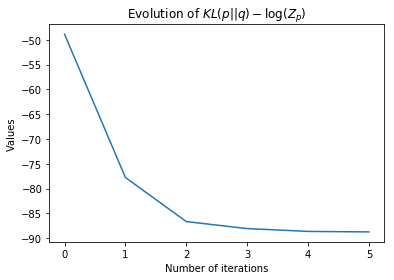

In [66]:
Mean_Field()

In [62]:
def distance_two_methods(nb_test):
    
    d = []
    
    for k in range(nb_test):
        
        tau = Mean_Field(plot_graph=False)
        mu = Gibbs_Sampling()
        d.append(np.mean(np.abs(tau - mu)))
    
    return(d)

In [63]:
d = distance_two_methods(5)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:14<00:00, 413.02it/s]


In [64]:
print(d)

[0.02831744794798954, 0.028851760079552896, 0.02852599594966792, 0.029309438412771775, 0.028854148427464876]
